In [15]:
#Requirements
#!pip install torchdyn
#!pip install torchdiffeq
#!pip install POT

In [16]:
import torch
import os
import argparse
import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ot as ot
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm
from torchdiffeq import odeint_adjoint as odeint
from torchdyn.datasets import generate_gaussians, generate_moons, generate_concentric_spheres

In [17]:
"""Data Sampler and utils"""

def sample_normal(n, mu=torch.zeros(2), sigma=1):
    distr = torch.distributions.MultivariateNormal(mu, sigma*torch.eye(2))
    return distr.sample((n,))

def sample_gaussians(n, n_gaussians=7):
    num = int(n/n_gaussians)+1
    x0, _ = generate_gaussians(num, n_gaussians, radius=4, std_gaussians=.5)
    return x0[:n]

def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 4 - 2

def sample_circles(n):
    x0, _ = generate_concentric_spheres(n , dim=2, inner_radius=.5, outer_radius=1)
    return x0

class sampler():
    def __init__(self, dataset: str):
        if dataset == "normal":
            self.sampler = sample_normal
        elif dataset == "gaussians":
            self.sampler = sample_gaussians
        elif dataset == "moons":
            self.sampler = sample_moons
        elif dataset == "circles":
            self.sampler = sample_circles
        else:
            raise Exception("Selected Dataset not supported. Choose between normal, gaussians, moons or circles")

    def __call__(self, n: int):
        return self.sampler(n)

"""utils"""
def initial_setup(x, y):
    fig, ax = plt.subplots()
    ax.scatter(x[:,0],x[:,1], c="royalblue", s=1, label="initial dataset")
    ax.scatter(y[:,0], y[:,1], c="darkorange", s=1, label="target dataset")
    ax.set_title("initial and target distributions")
    
    return fig, ax

def save_hyperparameters_and_metrics(file_path: str, hyperparameters: dict, metrics: dict):
    with open(file_path, "w") as file:
        file.write("Hyperparameters:\n")
        for param, value in hyperparameters.items():
            file.write(f"{param}: {value}\n")

        file.write("\nMetrics per  batches:\n")
        file.write("batches, loss, negative_log_likelihood, flow_length, wasserstein2_distance, elapsed_time\n")
        for  batches in range(len(metrics["batches"])):
            file.write(f"{metrics['batches'][batches]}, {metrics['loss'][batches]}, {metrics['log_probability'][batches]}, {metrics['flow_length'][batches]}, {metrics['wasserstein2_distance'][batches]}, {metrics['elapsed_time'][batches]}\n")
        
        file.write(f"total time: {sum(metrics['elapsed_time'])}")

def test_model(model_path: str, seed=44, samples=5):
    a = model_path.split("/")
    b = a[3]
    a = (a[1]).split("_")
    a.remove("to")

    model = MLP()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    if a[0]=="cfm":
        str_model_type, initial, target = a
        kin, frob = None, None

    else:
        str_model_type, target, kin, frob = a
        initial = "normal"

    torch.manual_seed(seed)
    np.random.seed(seed)

    initial_samples = sampler(initial)
    target_samples = sampler(target)



    log_probability = 0
    flow_length = 0
    wasserstein2_distance = 0

    for _ in range(samples):
        X = initial_samples(1000)
        Y = target_samples(1000)

        with torch.no_grad():
            trajectories = odeint(model, X, torch.linspace(1, 0, 100), method="rk4")
            log_probability += model.log_probability(torch.linspace(0, 1, 5), Y).item()
            flow_length += model.length_trajectories(trajectories).item()
            wasserstein2_distance += model.wasserstein2_distance(Y, trajectories)

    return log_probability/samples, flow_length/samples, wasserstein2_distance/samples, b

"""takes the path to a directory containing models as input and performs tests on all models in the directory. results are saved in test_log"""
def test_models(models_dir: str):
    models = [f for f in os.listdir(models_dir) if os.path.isfile(os.path.join(models_dir, f))]
    log_path = "/".join(models_dir.split("/")[:2]) + "/training_log.txt"
    a = 0
    with open(log_path, 'a') as test_file:
        test_file.write(f"\ntests \n")
        test_file.write("negative log-likelihood, flow length, wasserstein2 distance \n")
        for model in models:
            model_path = os.path.join(models_dir, model)
            log_likelihood, flow_length, wasserstein2, batch = test_model(model_path)
            test_file.write(batch + f": {log_likelihood}, {flow_length}, {wasserstein2} \n")


"""saves the model and the plots of the trajectories of the generated samples and updates the metrics at the current batch"""
def save(model: torch.nn.Module, trajectories: torch.Tensor, metrics: dict, X, Y, loss, batch, elapsed_time, args):

    torch.save(model.state_dict(), os.path.join(args.parameter_path + "/models", "batch_"+f"{batch}_model.pt"))         #saves the model

    fig, ax = model.plot_trajectories(trajectories)
    ax.set_title(f"{args.model_type}_{args.initial_dataset}_to_" + f"{args.target_dataset}")

    fig.savefig(os.path.join(args.parameter_path + "/trajectories", "batch_"+f"{batch}_trajectory.png"))                #saves the plot of the trajectories
    
    metrics["batches"].append(batch)
    metrics["log_probability"].append(model.log_probability(torch.linspace(0, 1, 5).type(torch.float32), Y))
    metrics["loss"].append(loss)
    metrics["flow_length"].append(model.length_trajectories(trajectories))
    metrics["wasserstein2_distance"].append(model.wasserstein2_distance(Y, trajectories))
    metrics["elapsed_time"].append(elapsed_time)

    return metrics


"""Dynamics, i.e., right hand side of the ODE"""
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=None, hidden_dim=256):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim + 1, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, t, x):
        if t.dim()==0:
            t = t.expand(x.size(0),)
        x = torch.cat((x, t[:,None]),dim=-1) 
        return self.net(x)
    
    """plots the ode solutions from its initial value x at time 0 to the final solution at time 1 (t decides number of steps)"""
    def plot_trajectories(self, trajectories=None, t=None, x=None):
        fig, ax = plt.subplots()
        with torch.no_grad():
            if trajectories == None:
                trajectories = odeint(self, x, t, method="rk4")

            ax.plot(trajectories[:,:,0], trajectories[:,:,1], color="silver", alpha=.7, zorder=0, label="flow")            
            ax.scatter(trajectories[0,:,0],trajectories[0,:,1], c="royalblue", s=1, label="prior sample", zorder=1)
            ax.scatter(trajectories[-1,:,0], trajectories[-1,:,1], c="darkorange", s=1, label="gen sample", zorder=1)

            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys())
        
        return fig, ax
    
    """log probability of the model with a normal gaussian as the initial distribution, esto esta mal luego pregunta"""
    def log_probability(self, t, x):
        initial_distr = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

        l0 = torch.zeros((x.size(0),1), requires_grad=False)
        initial_values = (x, l0)

        augmented_dynamics = Augmented_ODE(self)

        z_t, log_det = odeint(augmented_dynamics, initial_values, t, method="rk4")

        logp_x = initial_distr.log_prob(z_t[-1]) + log_det[-1]

        return -logp_x.mean()
    
    """computes the average length of the trajectories from the initial values x to the values at the final timestep"""
    def length_trajectories(self, trajectories=None, t=None, x=None):
        with torch.no_grad():
            if trajectories == None:
                trajectories = odeint(self, x, t, method="rk4")
            distances = torch.linalg.norm(trajectories[1:] - trajectories[:-1], dim=-1)
            length = distances.sum(dim=0)

            return length.mean()
        
    "computes the Wasserstein2 distance between samples generated from the initial values x and samples y from the true distribution"
    def wasserstein2_distance(self, y, trajectories=None, t=None, x=None):
        with torch.no_grad():
            if trajectories == None:
                trajectories = odeint(self, x, t, method="rk4")
            z = trajectories[-1]
            a, b = ot.unif(z.size(0)), ot.unif(y.size(0))
            cost = torch.cdist(z, y) ** 2
            distance = ot.emd2(a, b, cost.numpy())

            return distance**.5

    
"""Augmented ODE for CNF without any regularization and choice of samples for the Hutchinson trace estimator"""
class Augmented_ODE(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        with torch.no_grad():
            z = states[0]
            dz_dt, dlogp_z_dt =  self.hutchinson_trace_estimator(t, z)
            return (dz_dt, dlogp_z_dt)
        
    def hutchinson_trace_estimator(self, t, z, samples=20):
        trace = 0
        
        for _ in range(samples):
            epsilon = torch.randn_like(z)
            output_f, vjp_f = torch.autograd.functional.vjp(self.odefunc, (t,z), v=epsilon, create_graph=True)
            trace +=  (vjp_f[1]*epsilon).sum(1).unsqueeze(1)    

        return output_f, trace/samples

"""Augmented ODE to train RNODE"""
class regularized_Augmented_ODE(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        with torch.set_grad_enabled(True):
            z = states[0]                                                               #dynamics 
            dz_dt, vjp_f, epsilon = self.vjp(self.odefunc, t, z)
            dlog_det_dt =  (vjp_f*epsilon).sum(1).unsqueeze(1)                           #log-det of the Jacobian   
            dE_dt = (torch.linalg.vector_norm(dz_dt, dim=1, keepdims=True)**2)          #kinetic Energy
            dn_dt = (torch.linalg.vector_norm(vjp_f, dim=1, keepdims=True)**2)          #Frobenius norm of the Jacobian
            return (dz_dt, dlog_det_dt, dE_dt, dn_dt)

    def vjp(self, f, t, z):
        """computes vector Jacobian product and returns (output of the function, vjp, epsilon)"""
        epsilon = torch.randn_like(z)
        output_f, vjp_f = torch.autograd.functional.vjp(f, (t,z), v=epsilon, create_graph=True)
        return output_f, vjp_f[1], epsilon


"""Helper class to sample and compute the OT plan, as well as the conditional location and flow"""
def padding(t, x):
    if isinstance(t, (float, int)):
        return t
    return t.view([x.size(0)] + [1] * (x.dim() - 1))

class Conditional_FM():
    def __init__(self, sigma=0):
        self.ot_solver = ot.emd
        self.sigma = sigma
    
    def get_map(self, x0, x1):
        a, b = ot.unif(x0.size(0)), ot.unif(x1.size(0))
        cost = torch.cdist(x0, x1) ** 2
        pi = self.ot_solver(a, b, cost.numpy())

        return pi
    
    def sample_OT(self, x0, x1, batch_size: int):
        pi = self.get_map(x0, x1)
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(
            pi.shape[0] * pi.shape[1], p=p, size=batch_size)
        i, j = np.divmod(choices, pi.shape[1])
    
        return x0[i], x1[j]  
    
    def sample_location_and_conditional_flow(self, x0, x1):
        t = torch.rand(x0.shape[0]).type_as(x0)
        var = torch.randn_like(x0)
        padded_t = padding(t, x0)
        sigma_t = padding(self.sigma, x0)
        xt = padded_t * x1 + (1 - padded_t) * x0 +  sigma_t * var
        ut = x1 - x0

        return t, xt, ut  
    
    
"""computes the loss of RNODE, given the dynamics 'model' and samples 'x'"""
def rnode_loss(model: torch.nn.Module, x, args):
    initial_distr = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    t = torch.linspace(0, 1, 5).type(torch.float32)
    l0 = torch.zeros((x.size(0),1), requires_grad=True)
    kin_E0 = torch.zeros((x.size(0),1), requires_grad=True)
    n0 = torch.zeros((x.size(0),1), requires_grad=True)
    initial_values = (x, l0, kin_E0, n0)

    augmented_dynamics = regularized_Augmented_ODE(model)

    z_t, log_det, E_t, n_t = odeint(augmented_dynamics, initial_values, t,
                                    method=args.odeint_method,
                                    atol=args.odeint_atol,
                                    rtol=args.odeint_rtol)

    z1, l1, kin_E1, n1 = z_t[-1], log_det[-1], E_t[-1], n_t[-1]

    logp_x = initial_distr.log_prob(z1) + l1 -args.reg_kinetic_energy * kin_E1 - args.reg_frobenius_norm * n1
    loss = -logp_x.mean()

    return loss


"""computes the loss of CFM given the dynamics 'model', initial and target samples 'x0' and 'x1' respectively and batch size 'bs'"""
def cfm_loss(model: torch.nn.Module, x0, x1, bs):           #change order of x0 and x1 to obtain target at time 0 and initial at time 1
    flow_matcher = Conditional_FM()
    x0, x1 = flow_matcher.sample_OT(x0, x1, bs) 
    t, xt, ut = flow_matcher.sample_location_and_conditional_flow(x0, x1)
    
    loss = torch.mean((model(t,xt) - ut)**2)

    return loss


"""Training loop for RNODE"""
def rnode_training(args, metrics):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    model = MLP()

    initial_samples = sampler("normal")
    target_samples = sampler(args.target_dataset)

    X = initial_samples(1000)
    Y = target_samples(1000)

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    model.train()
    batch_save = int(args.num_batches/20)
    batch_loss = 0
    
    start = time.time()
    for i in tqdm(range(1, args.num_batches+1), desc="Training Batches"):
        optimizer.zero_grad()
        
        x = target_samples(args.batch_size)
        x.requires_grad = True

        loss = rnode_loss(model, x, args)

        loss.backward()
        optimizer.step()

        batch_loss += loss

        if i == 1:
            fig, ax = initial_setup(X, Y)
            fig.savefig(os.path.join(args.parameter_path + "/trajectories", "initial_target_distr.png"))

        elif i%batch_save == 0:
            end = time.time()
            elapsed_time = end-start

            loss = batch_loss/batch_save
            batch_loss = 0
            print(f"\nbatch {i}, Loss: {loss}")

            trajectories = odeint(model, X, torch.linspace(1, 0, 100).type(torch.float32), method="rk4")
            metrics = save(model, trajectories, metrics, X, Y, loss, i, elapsed_time, args)
            start = time.time()
            plt.close('all')


    print("finished training")

    return metrics


"""Training loop for OT-CFM"""
def cfm_training(args, metrics):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    model = MLP()

    initial_samples = sampler(args.initial_dataset)
    target_samples = sampler(args.target_dataset)

    X = initial_samples(1000)
    Y = target_samples(1000)

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    model.train()
    bs = args.batch_size
    batch_save = int(args.num_batches/5)
    batch_loss = 0

    start = time.time()
    for i in tqdm(range(1, args.num_batches+1), desc="Training Batches"):
        optimizer.zero_grad()

        x0, x1 = initial_samples(bs), target_samples(bs)

        loss = cfm_loss(model, x1, x0, bs)
        loss.backward()
        optimizer.step()

        batch_loss += loss

        if i == 1:
            fig, ax = initial_setup(X, Y)
            fig.savefig(os.path.join(args.parameter_path + "/trajectories", "initial_target_distr.png"))

        elif i%batch_save == 0:
            end = time.time()
            elapsed_time = end-start
            loss = batch_loss/batch_save
            batch_loss = 0
            print(f"batch {i}, Loss: {loss}")

            trajectories = odeint(model, X, torch.linspace(1, 0, 100).type(torch.float32), method="rk4")
            metrics = save(model, trajectories, metrics, X, Y, loss, i, elapsed_time, args)      
            start = time.time()
            plt.close('all')

    print("finished training")
    return metrics


"""combined training loop for rnode and cfm (if you want 'node+cfm' just set regularization constants to 0)"""
def combined_training(args, metrics):
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    model = MLP()

    initial_samples = sampler(args.initial_dataset)
    target_samples = sampler(args.target_dataset)

    X = initial_samples(1000)
    Y = target_samples(1000)

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    model.train()

    batch_save = int(args.num_batches/5)
    batch_loss = 0

    start = time.time()
    for i in tqdm(range(1, args.num_batches+1), desc="Training Batches"):
        optimizer.zero_grad()

        x0, x1 = initial_samples(args.batch_size), target_samples(args.batch_size)

        loss_cfm = cfm_loss(model, x1, x0, args.batch_size)
        loss_rnode = rnode_loss(model, x1, args)
        loss = args.cfm_loss_coefficient * loss_cfm + args.rnode_loss_coefficient * loss_rnode

        loss.backward()
        optimizer.step()

        batch_loss += loss

        if i == 1:
            fig, ax = initial_setup(X, Y)
            fig.savefig(os.path.join(args.parameter_path + "/trajectories", "initial_target_distr.png"))

        elif i%batch_save == 0:
            end = time.time()
            elapsed_time = end-start
            loss = batch_loss/batch_save
            batch_loss = 0
            print(f"batch {i}, Loss: {loss}")
            
            trajectories = odeint(model, X, torch.linspace(1, 0, 100).type(torch.float32), method="rk4")
            metrics = save(model, trajectories, metrics, X, Y, loss, i, elapsed_time, args)       
            start = time.time()  
            plt.close('all')
            
    print("finished training")
    return metrics


In [18]:
def training(model_type: str): #choices: "cfm" or "rnode"
    args = argparse.Namespace(
        model_type=model_type,
        initial_dataset="normal",
        target_dataset="moons",
        num_batches=10000,
        batch_size=200,
        learning_rate=1e-3,
        parameter_path="C:/",
        odeint_method="rk4",
        odeint_rtol=1e-3,
        odeint_atol=1e-3,
        reg_kinetic_energy=.1,
        reg_frobenius_norm=.1,
        seed=44,
        sigma = 0,
        rnode_loss_coefficient=1,
        cfm_loss_coefficient=1
    )

    print("Args parsed!", flush=True)
    print(f"Args: {args}", flush=True)

    hyperparameters = {
    "model_type": args.model_type,
    "learning_rate": args.learning_rate,
    "batch_size": args.batch_size,
    "num_batches": args.num_batches,
    "odeint_method": args.odeint_method,
    "seed": args.seed}

    metrics = {
    "batches": [],
    "loss": [],
    "log_probability": [],
    "flow_length": [],
    "wasserstein2_distance": [],
    "elapsed_time": []}


    if args.model_type == "rnode":
        args.parameter_path = args.parameter_path + f"{args.model_type}_to_" + f"{args.target_dataset}_kin" + f"{args.reg_kinetic_energy}_frob" + f"{args.reg_frobenius_norm}" 
        Path(os.path.join(args.parameter_path, "trajectories")).mkdir(parents=True, exist_ok=True)
        Path(os.path.join(args.parameter_path, "models")).mkdir(parents=True, exist_ok=True)
        hyperparameters["kinetic_regularization"] = args.reg_kinetic_energy
        hyperparameters["frobenius_regularization"] = args.reg_frobenius_norm
        metrics = rnode_training(args, metrics)

    elif args.model_type == "cfm":
        args.parameter_path = args.parameter_path + f"{args.model_type}_{args.initial_dataset}_to_" + f"{args.target_dataset}_sigma"+ f"{args.sigma}"
        Path(os.path.join(args.parameter_path, "trajectories")).mkdir(parents=True, exist_ok=True)
        Path(os.path.join(args.parameter_path, "models")).mkdir(parents=True, exist_ok=True)
        hyperparameters["sigma"] = args.sigma
        metrics = cfm_training(args, metrics)

    else:
        args.parameter_path = args.parameter_path + f"{args.model_type}_{args.initial_dataset}_to_" + f"{args.target_dataset}_rnode"+ f"{args.rnode_loss_coefficient}_cfm" + f"{args.cfm_loss_coefficient}"
        Path(os.path.join(args.parameter_path, "trajectories")).mkdir(parents=True, exist_ok=True)
        Path(os.path.join(args.parameter_path, "models")).mkdir(parents=True, exist_ok=True)
        hyperparameters["kinetic_regularization"] = args.reg_kinetic_energy
        hyperparameters["frobenius_regularization"] = args.reg_frobenius_norm
        hyperparameters["sigma"] = args.sigma
        hyperparameters["rnode_loss_coefficient"] = args.rnode_loss_coefficient
        hyperparameters["cfm_loss_coefficient"] = args.cfm_loss_coefficient
        metrics = combined_training(args, metrics)


    save_hyperparameters_and_metrics(os.path.join(args.parameter_path, "training_log.txt"), hyperparameters, metrics)


Args parsed!
Args: Namespace(model_type='rnode', initial_dataset='normal', target_dataset='moons', num_batches=1000, batch_size=256, learning_rate=0.001, parameter_path='C:/', odeint_method='rk4', odeint_rtol=0.001, odeint_atol=0.001, reg_kinetic_energy=0.1, reg_frobenius_norm=0.1, seed=44, sigma=0, rnode_loss_coefficient=1, cfm_loss_coefficient=1)


Training Batches:   5%|▍         | 49/1000 [00:05<01:56,  8.17it/s]


batch 50, Loss: 5.593203067779541


KeyboardInterrupt: 

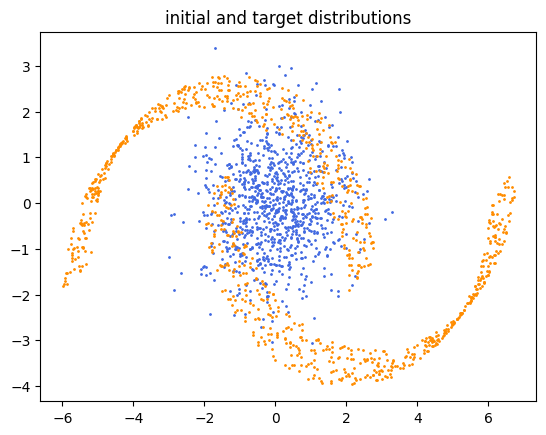

In [19]:
training("rnode")